In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
import pickle as pkl
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dropout, Concatenate,Dense
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize
from nltk.tokenize import MWETokenizer
import keras.backend as K
from keras.layers import Conv1D, Lambda, Bidirectional
from keras.models import Sequential
import keras

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#SETTING THE PATHS FOR FILES IN DRIVE
path = os.getcwd()
path = path + '/gdrive/My Drive/UIP Project Data'
glove_path = '/content/gdrive/MyDrive/UIP Project Data/glove.6B.100d.txt'
GLOVE_DIM = 100

In [ ]:
#READING FILE AND EXTRACTING ONLY USEFUL COLUMNS
data = pd.read_excel(os.path.join(path, 'training_set_rel3.xlsx'))
data = data[['essay_id','essay_set','essay','domain1_score']]

In [ ]:
#find max score of each essay set
set_score = {}
for i in range(1,9):
  set_score[i]=data[data['essay_set']==i]['domain1_score'].max() 
#print(set_score)
set_score[7] = 30
for i in range(1,9):
  data.loc[data['essay_set']==i,'domain1_score'] /= set_score[i]
### filtering essays with 'NaN' scores
data = data[data['domain1_score'].notnull()]
data['domain1_score'] = data['domain1_score'].round(2)

In [ ]:
data.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",0.67
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.75
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",0.58
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.83
4,5,1,"Dear @LOCATION1, I know having computers has a...",0.67


In [ ]:
### CLEANING TEXT BY REMOVING THE NUMBERS IN NER TAGS, CONVERTING TEXT TO LOWER CASE AND REMOVING UNNECCSARY CHARACTERS IN THE ESSAY
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = re.sub(r'CAPS[1-9]+',"caps",text)
    text = re.sub(r'LOCATION[1-9]+',"location",text)
    text = re.sub(r'CITY[1-9]+',"city",text)
    text = re.sub(r'STATE[1-9]+',"state",text)
    text = re.sub(r'MONTH[1-9]+',"month",text)
    text = re.sub(r'NUM[1-9]+',"num",text)
    text = re.sub(r'MONEY[1-9]+',"money",text)
    text = re.sub(r'DATE[1-9]+',"date",text)
    text = re.sub(r'ORGANISATION[1-9]+',"organisation",text)
    text = re.sub(r'PERSON[1-9]+',"person",text)
    text = re.sub(r'PERCENT[1-9]+',"percent",text)
    text = re.sub(r'EMAIL[1-9]+',"email",text)
    text = re.sub(r'DR[1-9]+',"dr",text)


    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/;:<>{}`+=~|]", "", text)

    return text

In [ ]:
#NER TAGS MENTIONED IN THE DATASET
NER_TAGS = ['caps','location','city','state','month','num','money','date','organisation','person','percent','email','dr']

In [ ]:
## TOKENIZING THE WORDS IN THE ESSAY AND PREVENTING @NER_TAG TO GET SPLIT INTO @ AND NER TAG SEPARATELY
def tokenize_text(text):
  tokens = nltk.word_tokenize(text)
  tokenizer = nltk.MWETokenizer(separator='')
  for i in range(len(NER_TAGS)):
    tokenizer.add_mwe(('@',NER_TAGS[i]))

  tokens = tokenizer.tokenize(tokens)
  return tokens

In [ ]:
#CLEANING THE ESSAYS IN THE DATAFRAME AND CREATING A NEW COLUMN IN THE DATAFRAME FOR TOKENISED WORDS IN THE ESSAYS
data['essay'] = data['essay'].apply(clean_text)
data['tokenized_essay'] = data['essay'].apply(tokenize_text)

In [ ]:
data.head()

,essay_id,essay_set,essay,domain1_score,tokenized_essay
0,1,1,"dear local newspaper, i think effects computer...",0.67,"[dear, local, newspaper, ,, i, think, effects,..."
1,2,1,"dear @caps @caps, i believe that using compute...",0.75,"[dear, @caps, @caps, ,, i, believe, that, usin..."
2,3,1,"dear, @caps @caps @caps more and more people u...",0.58,"[dear, ,, @caps, @caps, @caps, more, and, more..."
3,4,1,"dear local newspaper, @caps i have found that ...",0.83,"[dear, local, newspaper, ,, @caps, i, have, fo..."
4,5,1,"dear @location, i know having computers has a ...",0.67,"[dear, @location, ,, i, know, having, computer..."


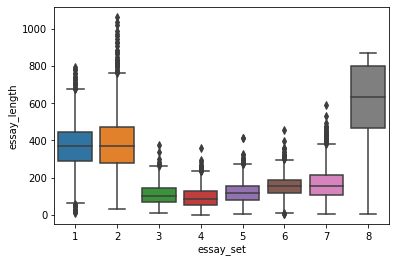

In [ ]:
##### NUMBER OF WORDS IN EACH DATASET
''' this is so that later if we want to embed or tokenize and we need the number
we can use these figures. but that will depend on the technique we use '''

data['essay_length'] = data['essay'].str.split().apply(len)
sns.boxplot(x='essay_set', y='essay_length', data= data)
data = data.drop('essay_length', axis=1)

In [ ]:
#### REMOVING ESSAYS THAT ARE SHORTER THAN 15 WORDS
TOO_SMALL_ESSAY_THRESHOLD = 15
data.drop(data[data['tokenized_essay'].map(len) < TOO_SMALL_ESSAY_THRESHOLD].index, inplace=True)

In [ ]:
# forming word2idx dict, idx2word dict, 'UNK' -> encoding text to sequence using the dictionaries formed
vocab = {}
for tok_essay in data['tokenized_essay']:
    for word in tok_essay:
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1

threshold = 10 


word_num  = 1
word2idx = {} #key is word, value is index of word
idx_to_word = {}  
 
#ASSIGN INDEX TO EVERY WORD IN VOCABULARY THAT OCCURS MORE THAN THE THRESHOLD LIMIT
for word, count in vocab.items():
    if count >= threshold: 
        word2idx[word] = word_num
        idx_to_word[word_num]=word 
        word_num += 1

word2idx['UNK'] = len(word2idx)+1 
idx_to_word[len(word2idx)+1] = 'UNK'

In [ ]:
#DISPLAYING EACH ESSAY AS A SET OF INDICIES USING THE word2idx DICTIONARY 
#MOST ESSAYS ARE IN THE 400 WORD RANGE,PAD THE ONES THAT ARE NOT
AVG_LEN = 500 
PADDING_ENCODING = 0

def encode_to_idx(essay):
  encoded_input = [0]*AVG_LEN
  for i in range(min(len(essay), AVG_LEN)):
    try:
      encoded_input[i] = word2idx[essay[i]]
    except:
      encoded_input[i] = word2idx['UNK']
  return encoded_input

In [ ]:
#ENCODING ALL TOKENISED ESSAYS AND STORING AS SEPARATE COLUMN
data['encoded_essay'] = data['tokenized_essay'].apply(encode_to_idx)

In [ ]:
data.head()

,essay_id,essay_set,essay,domain1_score,tokenized_essay,encoded_essay
0,1,1,"dear local newspaper, i think effects computer...",0.67,"[dear, local, newspaper, ,, i, think, effects,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,2,1,"dear @caps @caps, i believe that using compute...",0.75,"[dear, @caps, @caps, ,, i, believe, that, usin...","[1, 69, 69, 4, 5, 119, 161, 162, 8, 112, 163, ..."
2,3,1,"dear, @caps @caps @caps more and more people u...",0.58,"[dear, ,, @caps, @caps, @caps, more, and, more...","[1, 4, 69, 69, 69, 277, 27, 277, 11, 87, 8, 4,..."
3,4,1,"dear local newspaper, @caps i have found that ...",0.83,"[dear, local, newspaper, ,, @caps, i, have, fo...","[1, 2, 3, 4, 69, 5, 9, 226, 161, 164, 321, 336..."
4,5,1,"dear @location, i know having computers has a ...",0.67,"[dear, @location, ,, i, know, having, computer...","[1, 222, 4, 5, 135, 79, 8, 256, 58, 286, 287, ..."


In [ ]:
VOCAB_SIZE = len(word2idx)

In [ ]:
# CREATING WORD EMBEDDINGS USING GLOVE
def read_glove_vecs(file):
    with open(file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            word = line[0]
            words.add(word)
            word_to_vec_map[word] = np.array(line[1:], dtype=np.float64)
            
    return words, word_to_vec_map

words, word_to_vec_map = read_glove_vecs(glove_path)


# INITIALIZING EMBEDDING MATRIX FOR THE MODEL
embedding_matrix = np.zeros((VOCAB_SIZE+1, GLOVE_DIM))
for word, index in word2idx.items():
    try:
        embedding_matrix[index, :] = word_to_vec_map[word.lower()]
    except: continue

In [ ]:
#COUNTING NUMBER OF ESSAYS
num_essays = np.array(data['encoded_essay'].tolist()).shape[0]

In [ ]:
#EXTRACTING ENCODED ESSAYS AND THEIR SCORES FOR THE MODEL
essays = np.array(data['encoded_essay'].tolist())
print("input shape", essays.shape)
scores = np.array(data['domain1_score']).reshape(num_essays,1)
print("output shape", scores.shape)

input shape (12938, 500)
output shape (12938, 1)


In [ ]:
#SPLITTING DATA INTO TRAIN AND TEST SETS
p = np.random.permutation(len(data))
train_size = int(0.8*len(p))
train_idx = p[:train_size]
test_idx = p[train_size:]
x_train, x_test, y_train, y_test = essays[train_idx], essays[test_idx], scores[train_idx], scores[test_idx]

In [ ]:
x_train.shape

(10350, 500)

In [ ]:
#MODEL

EMBEDDING_DIM = 100
input_text = Input(shape=(AVG_LEN,))
embed_layer = Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=AVG_LEN, weights=[embedding_matrix], trainable=False)(input_text)
mot = Conv1D(filters=50, kernel_size=5, padding='same')(embed_layer)
lstm_model = Bidirectional(LSTM(300,dropout=0.25, return_sequences=True))(mot)
lstm_model = Bidirectional(LSTM(300,dropout=0.25, return_sequences=True))(lstm_model)
mot = Lambda(lambda x: K.mean(x, axis=1))(lstm_model)
output = Dropout(0.25)(mot)
output = Dense(1, activation="sigmoid")(mot) 

In [ ]:
model = Model(inputs=[input_text], outputs=[output])
model.compile(optimizer='adam' , loss='mse', metrics = ['mae']) 

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          652300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 50)           25050     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 600)          842400    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 600)          2162400   
_________________________________________________________________
lambda_1 (Lambda)            (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
history=model.fit(x=x_train, y=y_train,batch_size=256, epochs=30, verbose=1, validation_split = 0.1)

Epoch 1/30
37/37 [==============================] - 41s 1s/step - loss: 0.0397 - mae: 0.1579 - val_loss: 0.0287 - val_mae: 0.1332
Epoch 2/30
37/37 [==============================] - 41s 1s/step - loss: 0.0282 - mae: 0.1300 - val_loss: 0.0257 - val_mae: 0.1248
Epoch 3/30
37/37 [==============================] - 40s 1s/step - loss: 0.0254 - mae: 0.1222 - val_loss: 0.0236 - val_mae: 0.1192
Epoch 4/30
37/37 [==============================] - 40s 1s/step - loss: 0.0246 - mae: 0.1199 - val_loss: 0.0236 - val_mae: 0.1167
Epoch 5/30
37/37 [==============================] - 40s 1s/step - loss: 0.0231 - mae: 0.1159 - val_loss: 0.0255 - val_mae: 0.1221
Epoch 6/30
37/37 [==============================] - 40s 1s/step - loss: 0.0235 - mae: 0.1159 - val_loss: 0.0257 - val_mae: 0.1228
Epoch 7/30
37/37 [==============================] - 40s 1s/step - loss: 0.0247 - mae: 0.1214 - val_loss: 0.0248 - val_mae: 0.1210
Epoch 8/30
37/37 [==============================] - 40s 1s/step - loss: 0.0223 - mae: 0.11

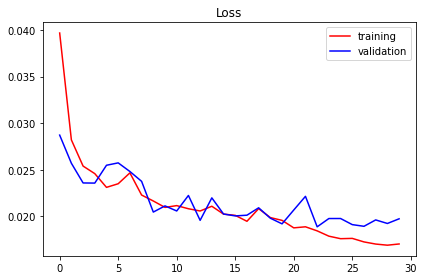

In [ ]:
#PLOTTING LOSS DURING TRAINING PROCESS
import matplotlib.pyplot as plt

plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="training")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

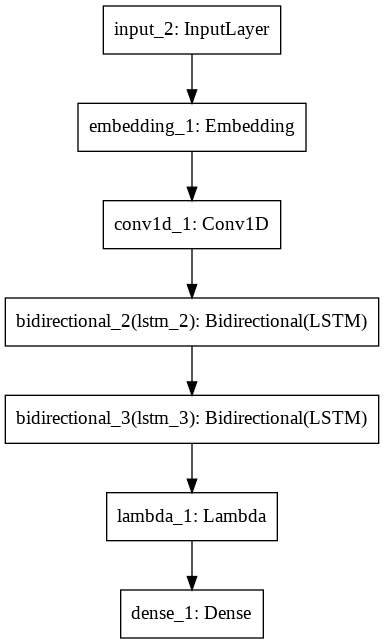

In [ ]:
plot_model(model)

In [ ]:
#####LOAD WEIGHTS ######
#model.load_weights(path+'/model_weights.h5')

In [ ]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pkl.load(f)

In [ ]:
model.load_weights(path+'/model_weights_final.h5')
os.chdir(path+'/final_model_data')

word2idx=load_obj("word2idx") 
train_x, train_y = load_obj("train")
x_test, y_test = load_obj("test")
x_test_df=load_obj("x_test_df")
test_idx=load_obj("x_test_idx")
idx_to_word=load_obj("idx_to_word")
data = load_obj("orig_data")
# idx_to_word=load_obj("idxword")
# vocab=load_obj(vocab,"vocab")

In [ ]:
# MAKE SCORE PREDICTION USING THE MODEL
from sklearn.metrics import cohen_kappa_score
y_pred = model.predict(x_test)
# y_pred= np.around(y_pred)

In [ ]:
x_test_df = data.iloc[test_idx,:].copy()
x_test_df['to_mult'] = x_test_df['essay_set'].apply(lambda x: set_score[x])
x_test_df['predicted_score'] = y_pred
x_test_df['predicted_score'] = x_test_df['predicted_score'] * x_test_df['to_mult']
x_test_df['predicted_score'] = np.around(x_test_df['predicted_score'])
x_test_df['predicted_score'] = x_test_df['predicted_score'].apply(int)
x_test_df['actual_score'] = x_test_df['domain1_score'] * x_test_df['to_mult']
x_test_df['actual_score'] = np.around(x_test_df['actual_score'])
x_test_df['actual_score'] = x_test_df['actual_score'].apply(int)

In [ ]:
x_test_df

,essay_id,essay_set,essay,domain1_score,tokenized_essay,encoded_essay,to_mult,predicted_score,actual_score
5440,8994,4,the author of this essay includes those senten...,0.00,"[the, author, of, this, essay, includes, those...","[26, 303, 30, 247, 245, 466, 282, 2918, 181, 2...",3.0,1,0
2603,3798,2,how would you feel if your son or daughter saw...,0.67,"[how, would, you, feel, if, your, son, or, dau...","[37, 38, 34, 39, 40, 41, 2578, 49, 3286, 1155,...",6.0,4,4
3370,4565,2,there are lots and lots of arguments over the ...,0.50,"[there, are, lots, and, lots, of, arguments, o...","[56, 12, 307, 27, 307, 30, 3787, 236, 26, 5206...",6.0,4,3
9950,15898,6,in their attempts to allow dirigibles to dock ...,0.75,"[in, their, attempts, to, allow, dirigibles, t...","[96, 380, 5457, 20, 931, 6262, 20, 6263, 10, 2...",4.0,3,3
4176,6572,3,many features of the setting affected the cycl...,1.00,"[many, features, of, the, setting, affected, t...","[164, 2504, 30, 26, 75, 2584, 26, 5850, 53, 46...",3.0,2,3
...,...,...,...,...,...,...,...,...,...
7569,12315,5,there were many moods set by the @caps in the ...,0.75,"[there, were, many, moods, set, by, the, @caps...","[56, 359, 164, 5723, 1451, 93, 26, 69, 96, 26,...",4.0,3,3
8472,13218,5,the author creates a mood in this memoir. the ...,0.50,"[the, author, creates, a, mood, in, this, memo...","[26, 303, 1132, 58, 4223, 96, 247, 6166, 53, 2...",4.0,2,2
8803,13549,5,in the excerpt narciso rodriguez from home the...,0.75,"[in, the, excerpt, narciso, rodriguez, from, h...","[96, 26, 6144, 6167, 6168, 539, 127, 26, 3049,...",4.0,3,3
11679,18934,7,patience is having control over yourself write...,0.57,"[patience, is, having, control, over, yourself...","[6000, 43, 79, 2830, 236, 1035, 241, 34, 1309,...",30.0,10,17


In [ ]:
avg = 0
for essay_set in range(1,9):
  temp_df = x_test_df.loc[x_test_df.essay_set == essay_set,:].copy()
  
  y_pred = temp_df['predicted_score']
  y_true = temp_df['actual_score']
  k=cohen_kappa_score(y_true, y_pred, weights='quadratic')
  print("Kappa score of set "+ str(essay_set) +": ",k)
  avg+= len(temp_df)*k
  
avg = avg/len(x_test)

Kappa score of set 1:  0.7470846764622558
Kappa score of set 2:  0.6323257248611969
Kappa score of set 3:  0.6525120759763119
Kappa score of set 4:  0.727241953825404
Kappa score of set 5:  0.7476350641160394
Kappa score of set 6:  0.7711804740671204
Kappa score of set 7:  0.7002514331022394
Kappa score of set 8:  0.5369574942566624


In [ ]:
print('Average Kappa Score: ',avg)

Average Kappa Score:  0.7028528288034427


In [ ]:
print("Kappa on all essays together: ", cohen_kappa_score(x_test_df['actual_score'], x_test_df['predicted_score'], weights='quadratic'))

Kappa on all essays together:  0.9811409999987634


In [ ]:
from IPython.display import display, HTML 
display(HTML(x_test_df[['essay_set','essay','predicted_score','actual_score']].to_html())) 

,essay_set,essay,predicted_score,actual_score
5440,4,the author of this essay includes those sentences as the conclusion to make it that she will realize that they are coming back.,1,0
2603,2,"how would you feel if your son or daughter saw a naked picture of someone, kept hearing bad words from a song that was in the library! would you really want that for your child? thought a library was supposed to be a learning center, didnt know it was a bad place to be. people have their own opinions in everything! a lot of things these days are changing and it is not for the better! television, books, and music are becoming dirty and unenjoyable to people. please help try and help us stop this! we do not want it getting to our kids, like it has to others! some people like these kinds of things with bad actions in them! one thing that catches them is the beat, it just makes them want to start dancing. another reason why they like it is beacuse their friends like it also! people these days are becoming more of followers than leaders like they should be. when people grow up they usually have an idol whether its a singer, book writer, or actor. when that idol grows older it most likely isnt going to be the same person with the same thoughts it had @date, they change for the worse most of the time! they get caught up in drugs or the fame that it puts them in. when that happens people loose than interste in them unless they think its cool! it all just depends on the person! some people thrive off of these things! libraries are supposed to be for all ages! if a kid finds something that was bad at a library and tells their friends or parents thats just putting down the library and they are not going to want to go there anymore. this is just hurting the library because it will loose a lot of their buisness. young kids these days are being expossed to a lot of more things that they should'nt be! what little kids already know is sickning! hearing them say that they have boyfriends and girlfriends, and how they know bad words just at the age of @date! it might have to do with the parents or the friends the kids choose but in my opinion it is right! kid's are growing up way to fast because of the things that they know! movies, music, books, etc. are not like they used to be in the fifty's, even the eighty's, yeah they werent the best, but its gotten a little extreme theses days. the words that they say in songs, the things we see in movies, and the picture we see in magazines are getting out of hand. there should be a section that is blocked off only for eighteen and older that has all the bad things in the music, movies, and, magazine articlespicture. people shoud have id's that they have to have to get into this section! this is going to try and prevent kids from seeing what they are these days when they are at a young age. this might not even work, but its worth a try! the world is'nt a happy place anymore! it is filled with violence, sex, drugs, etc. some parents do not care about the things that their child does, says, or sees. it all just depends on the family. whether they believe in @caps or if they do not is another example of this! it always affects ther actions and thought! people try and do the littlest things, and they try and make a difference in the world. that is what people need to do, not get involved in horrible things. they need to get involved and stay out of these bad things seeing bad picture, hearing bad words, and watching horrible things in movies. try to make a difference! dont be a follower because it is not going ti get you anywhere in life! everything counts!",4,4
3370,2,"there are lots and lots of arguments over the censorship of books and how they could affect children. some people think that offensive books should be removed from library shelves. others think that they should be left up there for the people who want to read them to do so. some parents of children say that their child has became more offensive towards

In [ ]:
####SAVE MODEL WEIGHTS ###
# model.save_weights(path+'/model_weights_final.h5') 

In [ ]:
# os.chdir(os.getcwd()+"/gdrive/MyDrive/UIP Project Data/final_model_data")

In [ ]:
os.getcwd()

In [ ]:
# with open("train.pkl", "wb") as f:
#   pkl.dump([x_train, y_train], f)

# with open("test.pkl", "wb") as f:
#   pkl.dump([x_test, y_test], f)

# with open("x_test_df.pkl", "wb") as f:
#   pkl.dump(x_test_df, f)

# with open("orig_data.pkl", "wb") as f:
#   pkl.dump(data, f)

# with open("x_test_idx.pkl", "wb") as f:
#   pkl.dump(test_idx, f)

In [ ]:
# with open("word2idx.pkl", "wb") as f:
#   pkl.dump(word2idx, f)
# with open("idx_to_word.pkl", "wb") as f:
#   pkl.dump(idx_to_word, f)